Phase scramble our natural images.

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
#import winsound#sound alarm when code finishes, only in windows

from SemiNE.utils import *
from SemiNE.train import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 50
#BATCH_SIZE = 1000 #100
#LR = 0.05#original
LR=0.0001 # 1e-4
L2=0.0#L2=0.000001#L2 regularization

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig3_training_inputs.npy')
training_set = np.load('../data/fig3_training_set.npy')
test_inputs = np.load('../data/fig3_test_inputs.npy')
test_set = np.load('../data/fig3_test_set.npy')
movie_bgr_h5 = np.load('../data/fig3_movie_bgr_h5.npy')

In [5]:
movie_bgr_h5=np.transpose(movie_bgr_h5,(0,2,3,1))
print (movie_bgr_h5.shape)

(20000, 28, 28, 2)


(20000, 28, 28, 2)
(20000, 2, 28, 28)


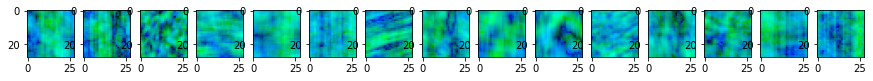

In [6]:
#phase scramble
#function: 2d fft for one image
#input: float, 1.0, gray image, random seed for generating random phase
#rescale:'cutoff': cutoff to the minimum and maximum of original image
#        'rescale': rescale to original range
#        'None': do nothing
#output: phase scrambled image, float, if rescale='None',the output could be a little larger than 1.0
def phase_scramble(img,seed,rescale='None'):
    """
    function: 2d fft for one image
    input: float, 1.0, gray image, random seed for generating random phase
    rescale:'cutoff': cutoff to the minimum and maximum of original image
            'rescale': rescale to original range
            'None': do nothing
    output: phase scrambled image, float, if rescale='None',the output could be a little larger than 1.0
    """
    f = np.fft.fft2(img)
    fmag = np.abs(f)
    fphase = np.angle(f)
    np.random.seed(seed)
    randomphase=np.angle(np.fft.fft2(np.random.rand(img.shape[0],img.shape[1])))
    #randomphase[0] = 0# leave out the DC value
    fphase=fphase+randomphase #randomphase #fphase+randomphase
    #np.random.shuffle(fphase)
    #fphase = 2.0 * np.pi * 1j * np.random.rand(*img.shape)
    img_scram = np.fft.ifft2(fmag*np.exp(1j*fphase))
    img_scram = np.abs(img_scram)
    #img_scram = np.real(img_scram)
    #
    if rescale=='rescale':
        img_min=np.min(img)
        img_max=np.max(img)
        img_scram=(img_scram-np.min(img_scram))/(np.max(img_scram)-np.min(img_scram))*(img_max-img_min)+img_min
    if rescale=='cutoff':
        img_min=np.min(img)
        img_max=np.max(img)
        img_scram[np.where(img_scram<img_min)]=img_min
        img_scram[np.where(img_scram>img_max)]=img_max
    if rescale=='None':
        pass
    return img_scram
#
temps=np.zeros_like(movie_bgr_h5)
for ii in range(len(temps)):
    for jj in range(temps.shape[3]):
        temp=movie_bgr_h5[ii,:,:,jj]/255.0
        temp=phase_scramble(temp,ii*3+jj,'None') # (temp,ii*3+jj,'None')
        temp=temp-np.min(temp)
        temp=temp/np.max(temp)
        temp=np.uint8(temp*255)
        temps[ii,:,:,jj]=temp
movie_bgr_h5=np.copy(temps)
del temps
print (movie_bgr_h5.shape)
#
fig, axes = plt.subplots(nrows=1, ncols=15,figsize=(15,2.5))
for ii in range(15):
    #axes[ii].imshow(movie_bgr_h5[51000+ii],cmap='gray',vmin=0,vmax=255)
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=movie_bgr_h5[9000+ii,:,:,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)#axes[ii,jj].axis('tight')
    #if ii==10:
        #cv2.imwrite('out_result/pha-scr-eg1.png', img_real2view(temp)[...,::-1])
    #if ii==11:
        #cv2.imwrite('out_result/pha-scr-eg2.png', img_real2view(temp)[...,::-1])
#
movie_bgr_h5=np.transpose(movie_bgr_h5,(0,3,1,2))
print (movie_bgr_h5.shape)

(array([[165947., 184211., 228168., 243065., 246054., 196535., 144790.,
          81611.,  39529.,  14412.],
        [167015., 191779., 247968., 271038., 279716., 228549., 167827.,
          95100.,  45911.,  16332.],
        [181169., 218830., 295538., 337205., 357447., 297360., 221326.,
         125661.,  61177.,  21142.],
        [171507., 214694., 303140., 357839., 390170., 329620., 248498.,
         141841.,  67983.,  23484.],
        [156205., 203090., 298327., 359229., 399421., 340885., 259360.,
         147285.,  70218.,  24200.],
        [116053., 155310., 232220., 285961., 319816., 274849., 211309.,
         120877.,  57603.,  19486.],
        [ 81321., 109116., 164617., 203776., 230954., 199866., 153677.,
          88167.,  42835.,  14292.],
        [ 44557.,  59660.,  89680., 111520., 125513., 108445.,  83046.,
          48786.,  23706.,   8010.],
        [ 21595.,  29161.,  42431.,  51827.,  57708.,  50383.,  38591.,
          22846.,  11012.,   3723.],
        [  8470.,  

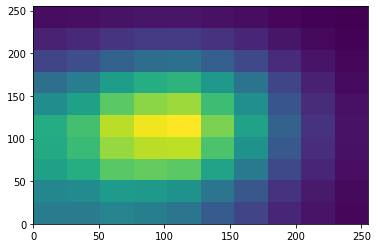

In [7]:
plt.hist2d(movie_bgr_h5[:18000,0,:,:].flatten(),movie_bgr_h5[:18000,1,:,:].flatten())

In [8]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
for ii in range(20):
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*900:ii*900+900] 
    temp=(temp0,temp1,temp2)
    #temp=(temp0,temp1)
    train_loader.append(temp)
#
temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
temp2=movie_bgr_h5[18000:19600]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[19600:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
20
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 96)
shape of train_loader[0][2]:
(900, 2, 28, 28)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 96)
shape of val_loader[2]:
(1600, 2, 28, 28)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 96)
shape of test_loader[2]:
(400, 2, 28, 28)


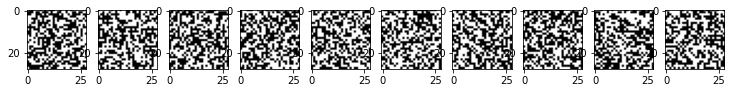

In [9]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

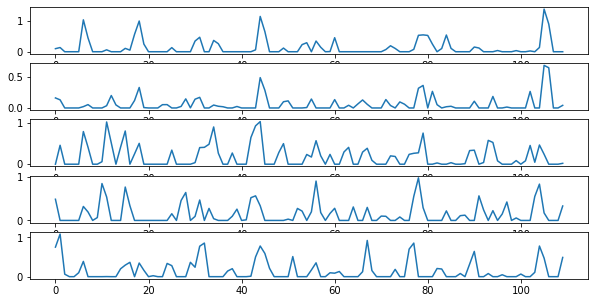

In [10]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

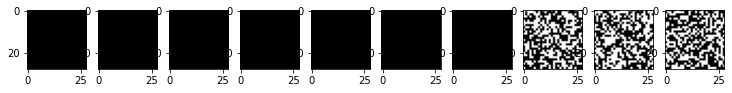

In [11]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

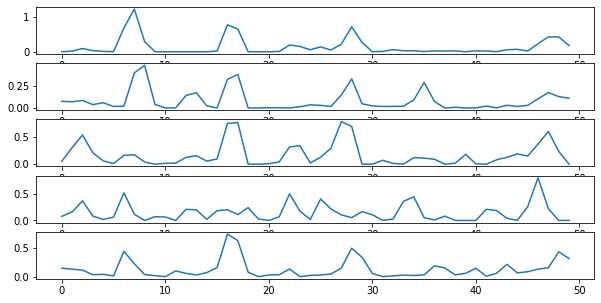

In [12]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

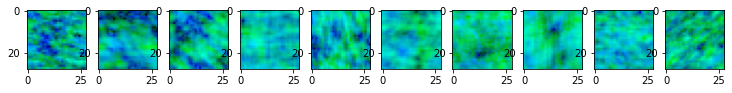

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    #axes[ii].imshow(train_loader[0][ii,0,...],cmap='gray',vmin=0,vmax=255)
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=np.transpose(train_loader[0][2][ii],(1,2,0))[...,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [14]:
#preprocess: centered data
#sky_bg_mean_f   =(0.10539950580232095, 0.23792787064825932)
sky_bg_mean_f   = np.mean(movie_bgr_h5[:18000],axis=(0,2,3))/255
print (sky_bg_mean_f)

[0.38153756 0.41681962]


In [15]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle):
    #UV channel
    weight_min=np.min(conv3d_0)
    weight_max=np.max(conv3d_0)
    if weight_max>(weight_min*(-1.0)):
        weight_min=weight_max*(-1.0)
    if weight_max<(weight_min*(-1.0)):
        weight_max=weight_min*(-1.0)
    #(outd,ind,height,weight)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=int(len(conv3d_0)/8), ncols=8,figsize=(10, int(len(conv3d_0)/8)))
    for ii in range(int(len(conv3d_0)/8)):
        for jj in range(8):
            axes[ii,jj].imshow(conv3d_0[ii*8+jj,0,...],vmin=weight_min,vmax=weight_max,cmap='bwr')
            axes[ii,jj].set_xticks([]),axes[ii,jj].set_yticks([])
            if ii==0 and jj==0:
                axes[ii,jj].set_title(str(temptitle))
    #plt.tight_layout()
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.5])
    #fig.colorbar(im, cax=cbar_ax)
    #fig.savefig('./out/ae3D_4_wL2_initDefault_sky_conv3d_0.svg')

##  <font color='red'>Model architecture</font> 

In [16]:
class ModelSemiSL3d1(nn.Module):
    def __init__(self):
        super(ModelSemiSL3d1, self).__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(8,1,1),stride=1)
        #fc layer
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #self.ae_conv1_b=nn.Parameter(torch.zeros(self.numoffea)).requires_grad_(requires_grad=True)
        #stdv           = 1. / np.sqrt(2*9*9)
        #self.ae_conv1_b.data.uniform_(-stdv, stdv)
        #
        self.ae_dconv1 =nn.ConvTranspose3d(self.numoffea,2,kernel_size=(1,9,9),stride=1,padding=(0,4,4))
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            GaussianNoise(sigma=1)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten3D(-1,self.numoffea,1,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_copy(nn.Module):
    def __init__(self,conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias):
        super(ModelSemiSL3d1_copy, self).__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(8,1,1),stride=1)
        #fc layer
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1_st.weight.data.copy_(conv1_st_weight.clone().detach())
        self.conv1_st.bias.data.copy_(conv1_st_bias.clone().detach())
        self.conv1_ss.data.copy_(conv1_ss.clone().detach())
        self.conv1_ss_bias.data.copy_(conv1_ss_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

##  <font color='red'>Different weights</font> 

In [19]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100 
alpha1s = [1e1]
alpha2s = [1e1]
beta1s  =[1/256] #[0.0,1/4,1,4,16]
alpha3s =[1e3]
beta2s  =[1/256] #[1/64]
seeds   =[1]
lossweights=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0] # [0.01]
#modeltrainloss=[]
modelvalloss=[]
for ii in range(len(seeds)):
    for jj in range(len(lossweights)):
        seedname=str(ii+1)
        modelname=str(jj+1)
        torch.manual_seed(seeds[ii])    # reproducible
        torch.cuda.manual_seed(seeds[ii])
        tempmodel = ModelSemiSL3d1()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=True) 
        #modeltrainloss.append(temp)
        #
        torch.save(tempmodel.state_dict(),\
                   './out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_'+seedname+'_weight_'+modelname+'.pth')
        
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss.append(temp)
        del tempmodel
        torch.cuda.empty_cache()

2020-11-02 13:19:35.664445
Model:  ModelSemiSL3d1 |Epoch:  0 | train loss: 1.0044
Model:  ModelSemiSL3d1 |Epoch:  1 | train loss: 0.6427
Model:  ModelSemiSL3d1 |Epoch:  2 | train loss: 0.4564
Model:  ModelSemiSL3d1 |Epoch:  3 | train loss: 0.4123
Model:  ModelSemiSL3d1 |Epoch:  4 | train loss: 0.4071
Model:  ModelSemiSL3d1 |Epoch:  5 | train loss: 0.4048
Model:  ModelSemiSL3d1 |Epoch:  6 | train loss: 0.4035
Model:  ModelSemiSL3d1 |Epoch:  7 | train loss: 0.4031
Model:  ModelSemiSL3d1 |Epoch:  8 | train loss: 0.4029
Model:  ModelSemiSL3d1 |Epoch:  9 | train loss: 0.4028
Model:  ModelSemiSL3d1 |Epoch:  10 | train loss: 0.4027
Model:  ModelSemiSL3d1 |Epoch:  11 | train loss: 0.4027
Model:  ModelSemiSL3d1 |Epoch:  12 | train loss: 0.4026
Model:  ModelSemiSL3d1 |Epoch:  13 | train loss: 0.4026
Model:  ModelSemiSL3d1 |Epoch:  14 | train loss: 0.4025
Model:  ModelSemiSL3d1 |Epoch:  15 | train loss: 0.4025
Model:  ModelSemiSL3d1 |Epoch:  16 | train loss: 0.4024
Model:  ModelSemiSL3d1 |Epoch: 

KeyboardInterrupt: 

In [19]:
print (modelvalloss)

[0.2711441389121134, 0.2717272970428414, 0.2698481282207687, 0.2715795063414835, 0.2723971199573448, 0.2707157157632034, 0.26692883257954186, 0.2733752685520939, 0.23216699017131295, 0.23205187874770203, 0]


In [21]:
#Use non-linear least squares to fit a 2d Gaussian function to conv0 and then measure the goodness of fit by r2
conv1_ss_s=[]
r2_s=[]
seeds=np.arange(1,11)
width,height=9,9
for seed in seeds:
    tempmodel= ModelSemiSL3d1()
    tempmodel.load_state_dict(torch.load(\
                './out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_'+str(seed)+'_weight_8.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() #print (conv1_ss.shape) # (16, 2, 1, 9, 9)
    conv1_ss_s.append(conv1_ss)
conv1_ss_s=np.array(conv1_ss_s)
print (conv1_ss_s.shape)
conv1_ss_s=np.reshape(conv1_ss_s,(-1,width*height))
print (conv1_ss_s.shape)
#
for ii in range(len(conv1_ss_s)):
    fit_2dgaussian=Fit_2dGaussian(conv1_ss_s[ii],(width,height))
    fit_2dgaussian.fit()
    r2_s.append(fit_2dgaussian.cal_r2())
r2_s=np.array(r2_s)
print (np.median(r2_s))
print (np.mean(r2_s))

(10, 16, 2, 1, 9, 9)
(320, 81)
0.17873687397467353
0.28790925714875637


In [19]:
weights=np.arange(2,11)
r2_ss=[]
seeds=np.arange(1,11)
width,height=9,9
for weight in weights:
    conv1_ss_s=[]
    r2_s=[]
    for seed in seeds:
        tempmodel= ModelSemiSL3d1()
        tempmodel.load_state_dict(torch.load(\
                './out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_'+str(seed)+'_weight_'+str(weight)+'.pth'))
        tempmodel=tempmodel.to(device_cpu)
        conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() #print (conv1_ss.shape) # (16, 2, 1, 9, 9)
        conv1_ss_s.append(conv1_ss)
    conv1_ss_s=np.array(conv1_ss_s)
    conv1_ss_s=np.reshape(conv1_ss_s,(-1,width*height))
    #
    for ii in range(len(conv1_ss_s)):
        fit_2dgaussian=Fit_2dGaussian(conv1_ss_s[ii],(width,height))
        fit_2dgaussian.fit()
        r2_s.append(fit_2dgaussian.cal_r2())
    r2_s=np.array(r2_s)
    r2_ss.append(r2_s)
r2_ss=np.array(r2_ss)
print (r2_ss.shape)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(9, 320)


(16, 2, 8, 9, 9)


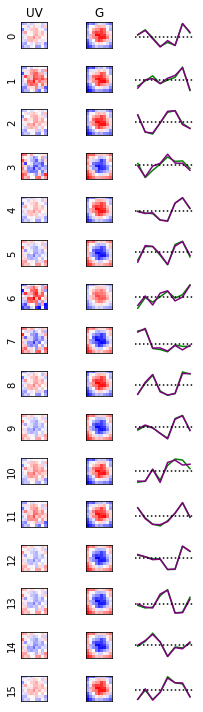

In [44]:
#visulize 3d subunits
modelname=9
tempmodel= ModelSemiSL3d1()
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_1_weight_'+str(modelname)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
#get parameters of model
#conv3d_0=ae3D_1_ground_127.encoder[0].weight.cpu().data.numpy()
#conv1_ss=tempmodel.conv1_ss.cpu().data.numpy()
#print (tempmodel.conv1_ss.shape) #torch.Size([16, 2, 1, 9, 9])
#print (tempmodel.conv1_st.weight.shape) #torch.Size([16, 16, 8, 1, 1])
RF_fl=torch.einsum('abcde, faghi->fbgde', tempmodel.conv1_ss.cpu().data.clone().detach(), \
            tempmodel.conv1_st.weight.cpu().data.clone().detach())
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (16, 2, 8, 9, 9)
print (RF_fl_np.shape)
#plot RFs
nt = 8 # time lag
ny = 9
nx = 9
dims = [nt, ny, nx]
nums_eg=np.arange(len(RF_fl_np))
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.5)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(ii))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g')
    axes[ii,2].plot(tRF_UV,color='purple')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

(16, 2, 8, 9, 9)


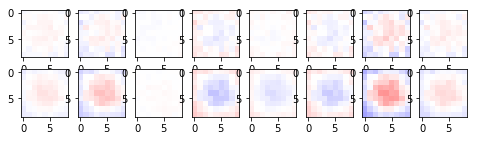

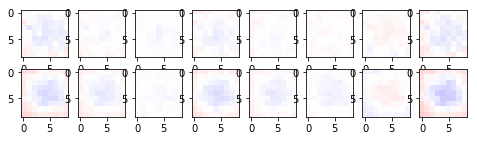

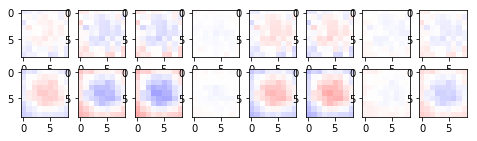

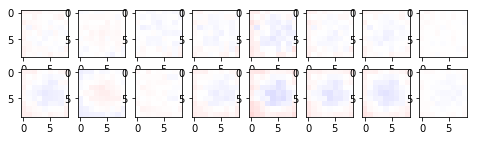

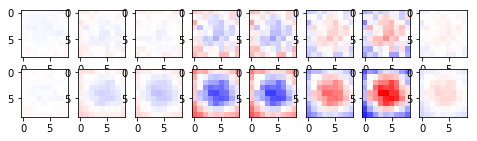

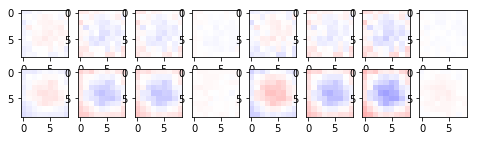

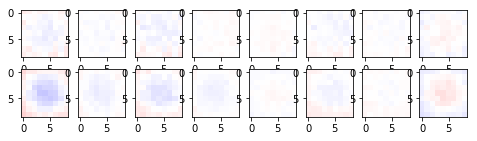

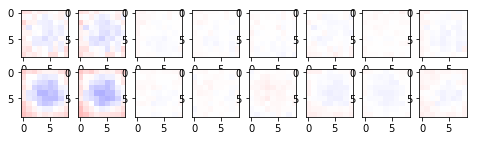

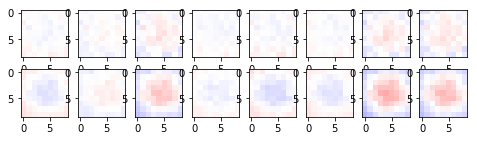

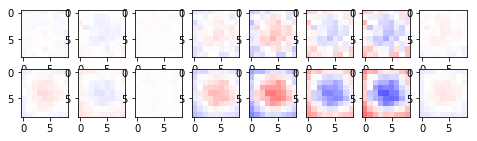

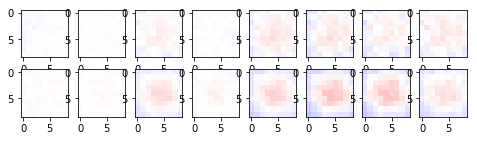

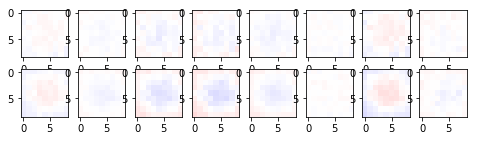

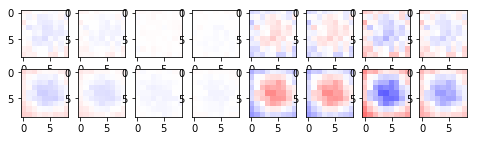

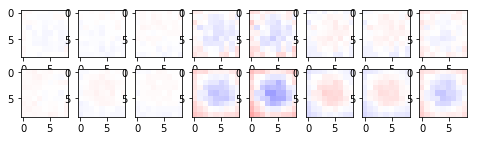

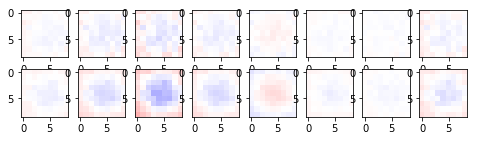

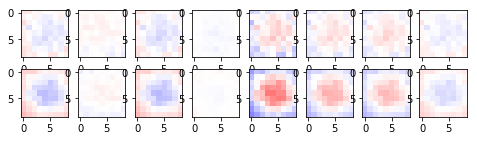

In [45]:
print (RF_fl_np.shape)
ncols=RF_fl_np.shape[2]
for ii in range(RF_fl_np.shape[0]):
    fig,axes=plt.subplots(nrows=2,ncols=ncols,figsize=(ncols,2))
    tempmax=np.max(np.abs(RF_fl_np))
    for jj in range(ncols):
        axes[0,jj].imshow(RF_fl_np[ii,0,jj],vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,jj].imshow(RF_fl_np[ii,1,jj],vmin=-tempmax,vmax=tempmax,cmap='bwr')

##  <font color='red'>Other random seeds after fixing alphas, alpha2s, betas</font> 

In [19]:
modelvalloss=np.zeros((10,10)) # 10 seeds x 10 weights
for ii in range(modelvalloss.shape[0]):
    seed_str=str(ii+1)
    for jj in range(modelvalloss.shape[1]):
        weight_str=str(jj+1)
        tempmodel = ModelSemiSL3d1()
        tempmodel.load_state_dict(torch.load\
            ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_'+seed_str+'_weight_'+weight_str+'.pth'))
        tempmodel=tempmodel.to(device_cpu)
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss[ii,jj]=temp
print (modelvalloss)
print (np.mean(modelvalloss,axis=0))

[[0.27114414 0.27509858 0.27594994 0.27524765 0.27504393 0.27398275
  0.27679594 0.29086977 0.23219666 0.23205357]
 [0.25978334 0.26302523 0.26947232 0.27703615 0.28277057 0.28708471
  0.29489465 0.30914666 0.23208511 0.23188689]
 [0.27312145 0.27456596 0.27943623 0.28138425 0.28508603 0.28538391
  0.29004046 0.30056735 0.23231755 0.23206988]
 [0.26111683 0.27238095 0.27622835 0.27751923 0.27953154 0.28452694
  0.28946281 0.29799424 0.31199084 0.2322007 ]
 [0.26866036 0.26332986 0.26496808 0.26573366 0.26815618 0.27183131
  0.27712577 0.28690884 0.23198656 0.23180935]
 [0.2564578  0.2577052  0.26187098 0.27168784 0.28217706 0.28818638
  0.29330891 0.29750966 0.30218946 0.23773607]
 [0.28132568 0.29087583 0.2939337  0.29548415 0.29715232 0.29891002
  0.29983344 0.30102762 0.30464863 0.23269375]
 [0.28487015 0.28433705 0.28167838 0.28032848 0.28263873 0.28513455
  0.28805343 0.29909386 0.31273016 0.2334241 ]
 [0.26725602 0.26346241 0.26945122 0.27511471 0.27532007 0.28288975
  0.28705395

In [19]:
# rebuttal
modelvalloss=np.zeros((10,11)) # 10 seeds x 11 weights
for ii in range(modelvalloss.shape[0]):
    seed_str=str(ii+1)
    for jj in range(modelvalloss.shape[1]):
        weight_str=str(jj+1)
        tempmodel = ModelSemiSL3d1()
        tempmodel.load_state_dict(torch.load\
            ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_'+seed_str+'_weight_'+weight_str+'.pth'))
        tempmodel=tempmodel.to(device_cpu)
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss[ii,jj]=temp
print (modelvalloss)
print (np.mean(modelvalloss,axis=0))

[[ 0.27114413  0.27509858  0.27594994  0.27524765  0.27504393  0.27398274
   0.27679594  0.29086976  0.23219666  0.23205356  0.        ]
 [ 0.25978334  0.26302523  0.26947232  0.27703615  0.28277058  0.28708471
   0.29489465  0.30914667  0.23208511  0.2318869   0.        ]
 [ 0.27312146  0.27456596  0.27943623  0.28138425  0.28508603  0.28538391
   0.29004046  0.30056736  0.23231755  0.23206988 -0.04154574]
 [ 0.26111682  0.27238095  0.27622836  0.27751922  0.27953154  0.28452693
   0.28946281  0.29799423  0.31199084  0.23220071  0.        ]
 [ 0.26866036  0.26332987  0.26496807  0.26573365  0.26815619  0.27183131
   0.27712577  0.28690885  0.23198655  0.23180935  0.02298357]
 [ 0.2564578   0.2577052   0.26187098  0.27168783  0.28217706  0.28818638
   0.29330891  0.29750967  0.30218947  0.23773608  0.        ]
 [ 0.28132568  0.29087584  0.2939337   0.29548416  0.29715232  0.29891002
   0.29983344  0.30102763  0.30464863  0.23269376  0.        ]
 [ 0.28487016  0.28433705  0.28167838  0.

Overall pearson correlation coefficient:  0.4904871870497855  and p-value:  6.923970331708136e-249
Overall pearson correlation coefficient:  0.5425203343535289  and p-value:  1.063742842e-314
Overall pearson correlation coefficient:  0.4906758185943354  and p-value:  4.18611051877745e-249
Overall pearson correlation coefficient:  0.5087533959979373  and p-value:  1.0661230736567885e-270
Overall pearson correlation coefficient:  0.500997020562444  and p-value:  2.8337754235316204e-261
Overall pearson correlation coefficient:  0.4886817935035352  and p-value:  8.416345545051919e-247
Overall pearson correlation coefficient:  0.5340982423045093  and p-value:  2.968937861085332e-303
Overall pearson correlation coefficient:  0.49711181313870983  and p-value:  1.2090232937798272e-256
Overall pearson correlation coefficient:  0.5127751930662394  and p-value:  1.1072330554341966e-275
Overall pearson correlation coefficient:  0.49186454349810615  and p-value:  1.7434906115684836e-250
[0.49048719

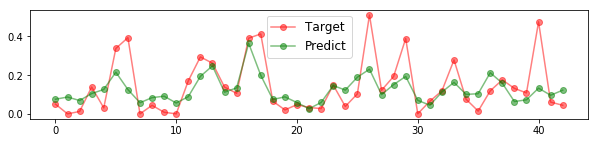

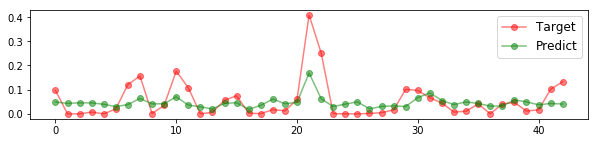

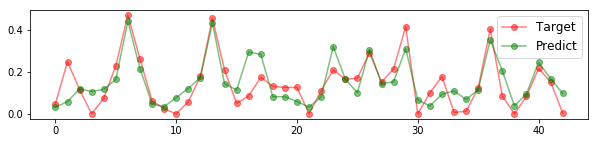

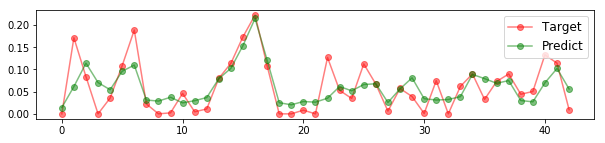

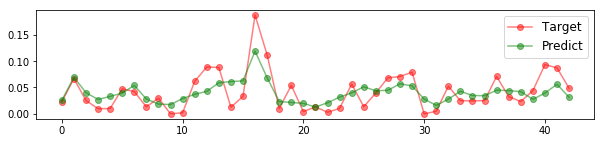

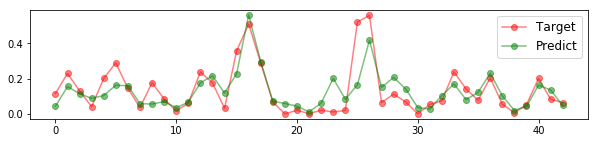

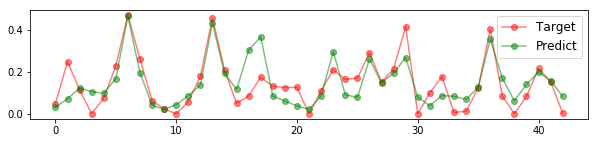

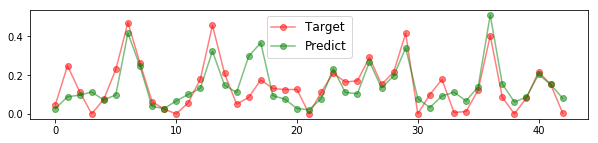

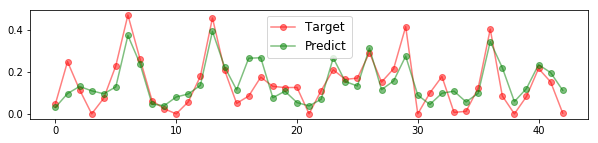

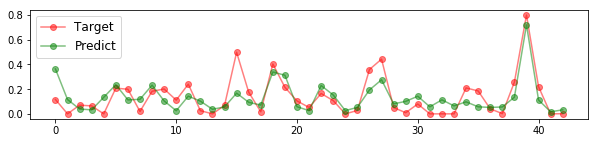

In [20]:
#test model
modeltestloss=[]
for ii in range(10):
    modelname=str(ii+1)
    tempmodel = ModelSemiSL3d1()
    tempmodel.load_state_dict(torch.load\
        ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_'+modelname+'_weight_8'+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    CC,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
    modeltestloss.append(CC)

torch.cuda.empty_cache()
modeltestloss=np.array(modeltestloss)
print (modeltestloss)
print (np.mean(modeltestloss))

(96, 2, 8, 28, 28)


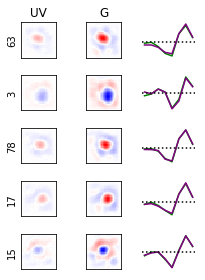

In [27]:
# save svd results of example neuronal RFs
nt = 8 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
#
#visualize final layer of model
tempmodel= ModelSemiSL3d1()
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_6_weight_'+str(8)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1_st_weight  =tempmodel.conv1_st.weight.data.clone().detach()
conv1_st_bias  =tempmodel.conv1_st.bias.data.clone().detach()
conv1_ss  =tempmodel.conv1_ss.data.clone().detach()
conv1_ss_bias   =tempmodel.conv1_ss_bias.data.clone().detach()
fc1_weight=tempmodel.fc1.weight.data.clone().detach()
fc1_bias  =tempmodel.fc1.bias.data.clone().detach()
tempmodel= ModelSemiSL3d1_copy(conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias)
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,8,28,28))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (50,2,28,28)
print (RF_fl_np.shape)
#nums_eg=np.arange(len(RF_fl_np))
#
#plot RFs
nums_eg=[63,3,78,17,15] #np.arange(len(RF_fl_np)) [63,3,78,17]
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1))) # /1.1
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

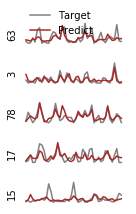

In [28]:
#plot prediction results for example neurons
tempmodel= ModelSemiSL3d1()
tempmodel.load_state_dict(torch.load\
                    ('./out/20200429_v4_ModelSemiSL3d1_dorsal_upandlow_phasescramble_seed_6_weight_'+str(8)+'.pth'))
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y,z)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu) 
z=z/255.0
z[:,0,:,:]=z[:,0,:,:]-sky_bg_mean_f[0]
z[:,1,:,:]=z[:,1,:,:]-sky_bg_mean_f[1]
z = z[:,:,np.newaxis,:,:]
b_z = torch.from_numpy(z).float().to(device_cpu)
with torch.no_grad():
    encoded,_,_ = tempmodel(b_x,b_z)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[7:,:] #use_pad0_sti=False
y=y[7:,:] #use_pad0_sti=False
#
nums_eg=[63,3,78,17,15] 
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.5)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='brown',linestyle='-',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    #axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()